In [1]:
import numpy as np
import pandas as pd
import sys
import re
import time
import datetime
from time import time, gmtime, strftime
from datetime import datetime
import statistics
from tqdm import tqdm_notebook as tqdm
from __future__ import division
from collections import Counter
from gensim import models
import gensim, logging
from gensim.models import Word2Vec
import pickle
import seaborn as sns
from copy import deepcopy

from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold, LeavePOut
from sklearn.linear_model import LogisticRegression, ElasticNet, SGDClassifier, LogisticRegressionCV, RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, cohen_kappa_score, roc_auc_score, roc_curve, auc, mutual_info_score, average_precision_score, precision_recall_curve
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from nltk.tokenize import word_tokenize as tokenizer
import jellyfish
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell # no need of print for several objects!!!
InteractiveShell.ast_node_interactivity = "all"

#pd.set_option('display.height', 1000)
#pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)

%matplotlib inline

init_vec = True

Using TensorFlow backend.


#### Filter editor-oriented text

In [13]:
string_pattern = '([a-zA-Z0-9ÀàÂâÆæÇçÈèÉéÊêËëÎîÏïÔôŒœÙùÛûÜü€₣]+|ref>|/ref>|\n\t|\'|[«».,\/#\|!$%\^&\*;:<>\[\]{}=\-_`~()])'

def wiki_normalize(s):
    s = re.sub(r'\[\[(?:[^\]|]*\|)?([^\]|]*)\]\]', r'\1', s.strip().lower())

    for element in [',', "pdf", "refnec", "référence nécessaire", "référence souhaitée", "..."]:
        s = s.replace("{{"+element+"}}","")
    s = re.sub(r'\{\{(?:[^\}|]*\|)?([^\}|]*)\}\}', r'\1', s.strip().lower())
    # remove {{ }} and remove {{a| from 

    #s = re.sub("\[[^\|]+\]", ' ', s.strip().lower())
    for element in ['\n', "'''''", "''''", "'''", "''"]:
        s = s.replace(element, " ")

    
    s = re.sub('<ref[^<]+</ref>', ' ', s) # https://stackoverflow.com/questions/12225729/regex-to-remove-text-between-tags-in-notepad
    

    s = re.sub('\{\{[^\|]+\|', ' ', s) # in {{a|b}} remove {{a| that is left ({{ and | are already removed)

    s = re.sub('<[^>]*>', ' ', s)
    s = re.sub('\[http[^\s]+\s', ' ', s)
    
    for element in ['|','{{', '}}', 'formatnum:','[...]', '[',']']:
        s = s.replace(element, " ")
        
    return s

def text_input_builder_bow(path):
    
    content = []
    i=0
    for line in open(path, "r+").readlines():   
        if not line.startswith('<') and not line.isspace():
            i+=1
            line = line.lower()
            line = wiki_normalize(line)
            line = re.findall(string_pattern, line) # turns line to list where all tokens are split
            line = " ".join(line) # all tokens are gathered in one string again with whitespaces as separators
            content.append(line)
        #if i == 400000:
        #    break
    return content

#### Language models (LM)

Run the cell below if the LM is not available (vector size = 100)

In [20]:
'''
#model100
#%%monitor_cell language_model_100

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
path = '/media/hdd/sileo/wiki-fr/text/full_filtered_wiki.txt'

content_input = text_input_builder_bow(path) # list where each sentence is a string

new_input = [string.split() for string in content_input] # list where each sentence is a list

#input_sentences must be list of lists of tokens
# https://rare-technologies.com/word2vec-tutorial/
model = Word2Vec(new_input, hs=1, negative=0)

#model.save('/media/hdd/sileo/wiki-fr/text/full_filtered_language_model_100')
'''

"\n#model100\n#%%monitor_cell language_model_100\n\nlogging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)\npath = '/media/hdd/sileo/wiki-fr/text/full_filtered_wiki.txt'\n\ncontent_input = text_input_builder_bow(path) # list where each sentence is a string\n\nnew_input = [string.split() for string in content_input] # list where each sentence is a list\n\n#input_sentences must be list of lists of tokens\n# https://rare-technologies.com/word2vec-tutorial/\nmodel = Word2Vec(new_input, hs=1, negative=0)\n\n#model.save('/media/hdd/sileo/wiki-fr/text/full_filtered_language_model_100')\n"

Load pre-defined model (vector size = 100)

In [21]:
# load the model again
model = Word2Vec.load('/media/hdd/sileo/wiki-fr/text/full_filtered_language_model_100')

In [22]:
len(model.wv.vocab)

729651

Run the cell below if the LM is not available (vector size = 300)

In [23]:
'''
#model300
#%%monitor_cell language_model_300

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
path = '/media/hdd/sileo/wiki-fr/text/full_filtered_wiki.txt'

content_input = text_input_builder_bow(path) # list where each sentence is a string

new_input = [string.split() for string in content_input] # list where each sentence is a list

# input_sentences must be list of lists of tokens
# https://rare-technologies.com/word2vec-tutorial/
model = Word2Vec(new_input, size=300, hs=1, negative=0)

#model.save('/media/hdd/sileo/wiki-fr/text/full_filtered_language_model_300')
'''

"\n#model300\n#%%monitor_cell language_model_300\n\nlogging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)\npath = '/media/hdd/sileo/wiki-fr/text/full_filtered_wiki.txt'\n\ncontent_input = text_input_builder_bow(path) # list where each sentence is a string\n\nnew_input = [string.split() for string in content_input] # list where each sentence is a list\n\n# input_sentences must be list of lists of tokens\n# https://rare-technologies.com/word2vec-tutorial/\nmodel = Word2Vec(new_input, size=300, hs=1, negative=0)\n\n#model.save('/media/hdd/sileo/wiki-fr/text/full_filtered_language_model_300')\n"

Load pre-defined model (vector size = 300)

In [24]:
model = Word2Vec.load('/media/hdd/sileo/wiki-fr/text/full_filtered_language_model_300')

## Build news dataset

In [95]:
from sklearn.datasets import fetch_20newsgroups

Build news train and test datasets

In [137]:
# news
newsgroups_full = fetch_20newsgroups()
cats = ['rec.sport.baseball','rec.sport.hockey']
newsgroups_train = fetch_20newsgroups(subset='train', categories=cats)
newsgroups_test = fetch_20newsgroups(subset='test', categories=cats)

list(newsgroups_train.target_names)

newsgroups_train.filenames.shape
newsgroups_train.target.shape

unique, counts = np.unique(newsgroups_train.target, return_counts=True)
print(np.asarray((unique, counts)).T)
unique, counts = np.unique(newsgroups_test.target, return_counts=True)
print(np.asarray((unique, counts)).T)

df_train = pd.DataFrame(data=np.c_[newsgroups_train['data'], newsgroups_train['target']], columns=['string', 'incoherence'])
df_test = pd.DataFrame(data=np.c_[newsgroups_test['data'], newsgroups_test['target']], columns=['string', 'incoherence'])

df_train.incoherence = pd.to_numeric(df_train.incoherence)
df_test.incoherence = pd.to_numeric(df_test.incoherence)

['rec.sport.baseball', 'rec.sport.hockey']

(1197,)

(1197,)

[[  0 597]
 [  1 600]]
[[  0 397]
 [  1 399]]


In [138]:
def string_cleaner(string):
    return ' '.join(re.findall(r"\w+|[^\w\s]", string.lower(), re.UNICODE))

In [139]:
def len_calculator(df):
    for i in range(0, len(df)):
        df.loc[i,'string'] = string_cleaner(df.loc[i,'string'])
        df.loc[i,'len'] = len(df.loc[i,'string'])
        df.loc[i,'len_tok'] = len(re.findall(string_pattern, df.loc[i, 'string'].strip().lower()))
    
    return df

df_train = len_calculator(df_train)
df_test = len_calculator(df_test)

In [140]:
df_train[['len','len_tok']].describe()
df_test[['len','len_tok']].describe()

,len,len_tok
count,1197.000000,1197.000000
mean,1751.928989,422.340017
std,2787.340943,691.025013
min,178.000000,36.000000
25%,769.000000,177.000000
50%,1196.000000,277.000000
75%,1911.000000,462.000000
max,73596.000000,16503.000000


,len,len_tok
count,796.000000,796.000000
mean,1656.662060,394.265075
std,1321.934024,355.381303
min,171.000000,37.000000
25%,801.500000,181.000000
50%,1328.000000,302.000000
75%,1999.750000,487.250000
max,13588.000000,3988.000000


In [141]:
df_train.head(2)
df_test.head(2)

,string,incoherence,len,len_tok
0,from : dougb @ comm . mot . com ( doug bank ) ...,0,1121.0,242.0
1,from : gld @ cunixb . cc . columbia . edu ( ga...,1,832.0,221.0


,string,incoherence,len,len_tok
0,from : luriem @ alleg . edu ( michael lurie ) ...,0,776.0,173.0
1,from : acsddc @ smucs2 . umassd . edu subject ...,0,578.0,127.0


#### Functions

Choose either <code>cv_SKF</code>, <code>cv_RSKF</code> or <code>cv_LPO</code> for cross-validation setting.

In [142]:
cv_SKF = StratifiedKFold(n_splits=6, shuffle=True)
cv_RSKF = RepeatedStratifiedKFold(n_splits=6)
cv_LPO = LeavePOut(1)


def cross_val_series(X, y, clf, cv_input):
    
    metrics_list = ['precision', 'recall', 'f1', 'roc_auc'] #, 'neg_log_loss'
    df_scores = pd.DataFrame(index=metrics_list, columns=['score'])
    
    for metric in metrics_list:
        df_scores.loc[metric,'score'] = '{:.3f} (+/- {:.3f})'.format(cross_val_score(clf, X, y, cv=cv_input, scoring=metric).mean(), 1.96 * cross_val_score(clf, X, y, cv=cv_input, scoring=metric).std() / np.sqrt(len(cross_val_score(clf, X, y, cv=cv_input, scoring=metric))))
    return df_scores
    
    # roc_auc > needs to exceed 0.5
    # neg_log_loss > neg metric, needs to approach 0

Testing function.

In [143]:
def model_testing(X_train, y_train, X_test, y_test, model):
    
    metrics_list = ['precision', 'recall', 'f1', 'roc_auc']
    df_scores_test = pd.DataFrame(index=metrics_list, columns=['test_score'])
    
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    
    y_pred_proba = model.predict_proba(X_test)
    
    
    df_scores_test.loc['precision', 'test_score'] = '{:.3f}'.format(precision_score(y_test, y_pred))
    df_scores_test.loc['recall', 'test_score'] = '{:.3f}'.format(recall_score(y_test, y_pred))
    df_scores_test.loc['f1', 'test_score'] = '{:.3f}'.format(f1_score(y_test, y_pred))
    df_scores_test.loc['roc_auc', 'test_score'] = '{:.3f}'.format(roc_auc_score(y_test, y_pred_proba[:,1]))
    
    full_test_df = df_test.copy()
    full_test_df['y_test'] = pd.DataFrame(y_test)
    full_test_df['y_pred'] = pd.DataFrame(y_pred)
    full_test_df['y_pred_proba'] = pd.DataFrame(y_pred_proba[:,1])
    
    return df_scores_test, full_test_df, y_test, y_pred, y_pred_proba

Plot ROC curve.

In [144]:
def plot_roc_auc(y_test, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1], pos_label=1)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

## Method 1: BOW

Build new model (cell below) or load pre-existing model (next cell below)

In [145]:
%%time
#path = '/media/hdd/sileo/wiki-fr/text/full_filtered_wiki.txt'
#txt_input = text_input_builder_bow(path)
#vectorizer = CountVectorizer(max_features=4096)
#vectorizer.fit(txt_input)
##pickle.dump(vectorizer, open("vectorizer_bow.p", "wb"))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.1 µs


In [146]:
#vectorizer = pickle.load(open( "vectorizer_bow.p", "rb" ))

In [147]:
'''
print('Voc length: {:,}'.format(len(vectorizer.vocabulary_))) # max = 2,431,546

X_train = vectorizer.transform(df_train.string).toarray()
X_test = vectorizer.transform(df_test.string).toarray()

y_train = df_train.incoherence.values.copy()
y_test = df_test.incoherence.values.copy()
'''

"\nprint('Voc length: {:,}'.format(len(vectorizer.vocabulary_))) # max = 2,431,546\n\nX_train = vectorizer.transform(df_train.string).toarray()\nX_test = vectorizer.transform(df_test.string).toarray()\n\ny_train = df_train.incoherence.values.copy()\ny_test = df_test.incoherence.values.copy()\n"

In [148]:
#### news
vectorizer = CountVectorizer(max_features=4096)
vectorizer.fit_transform(newsgroups_full.data)
print('Voc length: {:,}'.format(len(vectorizer.vocabulary_))) 
X_train = vectorizer.transform(df_train.string).toarray()
X_test = vectorizer.transform(df_test.string).toarray()

y_train = df_train.incoherence.values.copy()
y_test = df_test.incoherence.values.copy()

<11314x4096 sparse matrix of type '<class 'numpy.int64'>'
	with 1305225 stored elements in Compressed Sparse Row format>

Voc length: 4,096


In [149]:
df_test.dtypes

string          object
incoherence      int64
len            float64
len_tok        float64
dtype: object

#### Dummy classifier

In [152]:
clf = DummyClassifier(strategy='stratified')
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

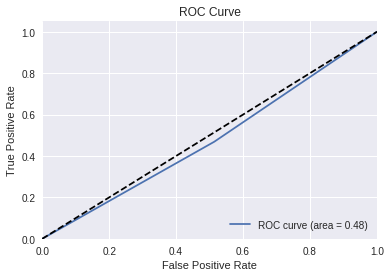

,score
precision,0.511 (+/- 0.037)
recall,0.505 (+/- 0.031)
f1,0.466 (+/- 0.023)
roc_auc,0.499 (+/- 0.030)


,test_score
precision,0.515
recall,0.469
f1,0.491
roc_auc,0.477


In [153]:
plot_roc_auc(y_test, y_pred_proba)
table
table_test

#### Logistic Regression classifier (best performance with string L2 regularization)

In [154]:
clf = LogisticRegression(solver='sag', n_jobs=-1, C=0.0000001)#, max_iter = 1000)
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

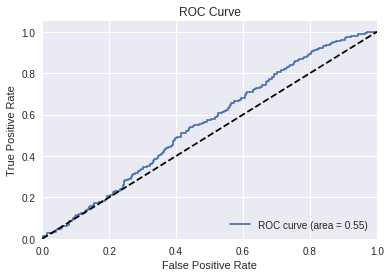

,score
precision,0.534 (+/- 0.001)
recall,0.988 (+/- 0.000)
f1,0.640 (+/- 0.019)
roc_auc,0.649 (+/- 0.031)


,test_score
precision,0.508
recall,0.990
f1,0.672
roc_auc,0.554


In [155]:
plot_roc_auc(y_test, y_pred_proba)
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [156]:
logreg_bow_df = full_test_df.copy()

1    395
0      4
Name: y_pred, dtype: int64

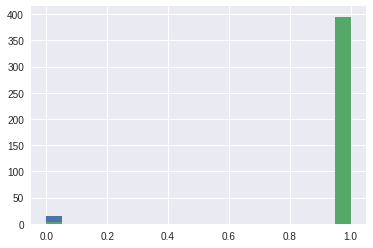

In [157]:
logreg_bow_df[logreg_bow_df.y_test == 0].y_pred.hist(bins=20)
logreg_bow_df[logreg_bow_df.y_test == 1].y_pred.hist(bins=20)
logreg_bow_df[logreg_bow_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

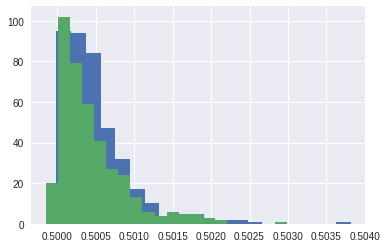

In [160]:
logreg_bow_df[logreg_bow_df.y_test == 1].y_pred_proba.hist(bins=20)
logreg_bow_df[logreg_bow_df.y_test == 0].y_pred_proba.hist(bins=20)


In [161]:
logreg_bow_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][logreg_bow_df.y_test==1].sort_values('y_pred_proba', ascending=False)
logreg_bow_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(logreg_bow_df.y_test == 1)&(logreg_bow_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
idx_list = logreg_bow_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(logreg_bow_df.y_test == 1)&(logreg_bow_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False).index.values.tolist()
#for i in idx_list:
#    print(logreg_bow_df.loc[i,'string'],'\n')
    
#for id_subset in logreg_bow_df.sample_id[(logreg_bow_df.y_test == 1)&(logreg_bow_df.y_pred == 1)].tolist():
#    print('comparison link:', '\t', 'https://fr.wikipedia.org/w/index.php?diff=' + str(df_XY.id[df_XY.sample_id==id_subset].values[0])+'&oldid='+str(int(df_XY.parentid[df_XY.sample_id==id_subset].values[0])),'\n')

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
307,from : jca2 @ cec1 . wustl . edu ( joseph char...,1,1,1,0.503816,6790.0,1618.0
282,from : etxonss @ ufsa . ericsson . se ( staffa...,1,1,1,0.502515,6339.0,1595.0
211,from : loh @ fraser . sfu . ca ( keith meng - ...,1,1,1,0.502460,3284.0,666.0
745,subject : flames final stats and playoff news ...,1,1,1,0.502308,6052.0,1564.0
791,from : dchhabra @ stpl . ists . ca ( deepak ch...,1,1,1,0.502279,4876.0,1100.0
448,from : stompkin @ tuba . calpoly . edu ( the e...,1,1,1,0.502234,4385.0,959.0
650,from : umturne4 @ ccu . umanitoba . ca ( daryl...,1,1,1,0.501891,4276.0,1026.0
228,from : hammerl @ acsu . buffalo . edu ( valeri...,1,1,1,0.501868,3700.0,790.0
263,from : thomas @ cmgm . stanford . edu ( thomas...,1,1,1,0.501866,3582.0,744.0
200,from : andrew @ idacom . hp . com ( andrew sco...,1,1,1,0.501818,6664.0,1761.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
307,from : jca2 @ cec1 . wustl . edu ( joseph char...,1,1,1,0.503816,6790.0,1618.0
282,from : etxonss @ ufsa . ericsson . se ( staffa...,1,1,1,0.502515,6339.0,1595.0
211,from : loh @ fraser . sfu . ca ( keith meng - ...,1,1,1,0.502460,3284.0,666.0
745,subject : flames final stats and playoff news ...,1,1,1,0.502308,6052.0,1564.0
791,from : dchhabra @ stpl . ists . ca ( deepak ch...,1,1,1,0.502279,4876.0,1100.0
448,from : stompkin @ tuba . calpoly . edu ( the e...,1,1,1,0.502234,4385.0,959.0
650,from : umturne4 @ ccu . umanitoba . ca ( daryl...,1,1,1,0.501891,4276.0,1026.0
228,from : hammerl @ acsu . buffalo . edu ( valeri...,1,1,1,0.501868,3700.0,790.0
263,from : thomas @ cmgm . stanford . edu ( thomas...,1,1,1,0.501866,3582.0,744.0
200,from : andrew @ idacom . hp . com ( andrew sco...,1,1,1,0.501818,6664.0,1761.0


#### Decision Tree classifier

In [162]:
clf = DecisionTreeClassifier()#criterion='entropy', splitter='random', class_weight='balanced')
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test = model_testing(X_train, y_train, X_test, y_test, clf)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

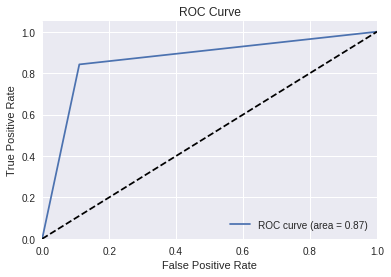

,score
precision,0.913 (+/- 0.020)
recall,0.875 (+/- 0.015)
f1,0.902 (+/- 0.026)
roc_auc,0.912 (+/- 0.015)


,test_score
precision,0.884
recall,0.842
f1,0.863
roc_auc,0.866


In [163]:
plot_roc_auc(y_test, y_pred_proba)
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [164]:
dt_bow_df = full_test_df.copy()

1    336
0     63
Name: y_pred, dtype: int64

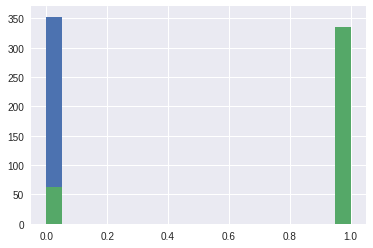

In [165]:
dt_bow_df[dt_bow_df.y_test == 0].y_pred.hist(bins=20)
dt_bow_df[dt_bow_df.y_test == 1].y_pred.hist(bins=20)
dt_bow_df[dt_bow_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

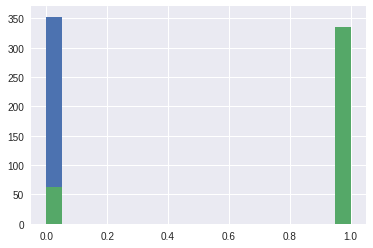

In [166]:
dt_bow_df[dt_bow_df.y_test == 0].y_pred_proba.hist(bins=20)
dt_bow_df[dt_bow_df.y_test == 1].y_pred_proba.hist(bins=20)

Display scores and detected positive samples

In [168]:
dt_bow_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][dt_bow_df.y_test==1].sort_values('y_pred_proba', ascending=True)
dt_bow_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(dt_bow_df.y_test == 1)&(dt_bow_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
idx_list = dt_bow_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(dt_bow_df.y_test == 1)&(dt_bow_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False).index.values.tolist()

#for i in idx_list:
#    print(dt_bow_df.loc[i,'string'],'\n')
    
#for id_subset in dt_bow_df.sample_id[(dt_bow_df.y_test == 1)&(dt_bow_df.y_pred == 1)].tolist():
#    print('comparison link:', '\t', 'https://fr.wikipedia.org/w/index.php?diff=' + str(df_XY.id[df_XY.sample_id==id_subset].values[0])+'&oldid='+str(int(df_XY.parentid[df_XY.sample_id==id_subset].values[0])),'\n')

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
382,from : chuq @ apple . com ( chuq von rospach )...,1,1,0,0.0,1220.0,278.0
313,from : nhmas @ gauss . med . harvard . edu ( m...,1,1,0,0.0,892.0,191.0
150,from : bgk2 < bgk2 @ musicb . mcgill . ca > su...,1,1,0,0.0,1101.0,259.0
321,organization : central michigan university fro...,1,1,0,0.0,426.0,97.0
136,from : kirchner @ informatik . tu - muenchen ....,1,1,0,0.0,2344.0,519.0
333,from : gwittt @ alleg . edu ( tom gwitt ) subj...,1,1,0,0.0,560.0,127.0
691,from : pavalin @ bnr . ca ( paul valin ) subje...,1,1,0,0.0,1551.0,376.0
335,from : 35002_2765 @ uwovax . uwo . ca subject ...,1,1,0,0.0,830.0,199.0
566,from : ccdb @ musica . mcgill . ca ( ccdb ) su...,1,1,0,0.0,686.0,146.0
126,subject : re : sharks review part 5 : left win...,1,1,0,0.0,1357.0,305.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
2,from : co398 @ cleveland . freenet . edu ( the...,1,1,1,1.0,1005.0,246.0
519,from : farenebt @ craft . camp . clarkson . ed...,1,1,1,1.0,2131.0,363.0
541,from : farenebt @ craft . camp . clarkson . ed...,1,1,1,1.0,1711.0,398.0
538,from : anna matyas < am2x + @ andrew . cmu . e...,1,1,1,1.0,2173.0,496.0
536,from : joe13 + @ pitt . edu ( joseph b stiehm ...,1,1,1,1.0,1748.0,391.0
532,from : klaty @ procyon . engin . umich . edu (...,1,1,1,1.0,717.0,150.0
531,from : jwh @ sei . cmu . edu ( john huber ) su...,1,1,1,1.0,2007.0,444.0
526,from : paul @ fugu . data - io . com ( paul br...,1,1,1,1.0,670.0,154.0
524,from : kfrank @ magnus . acs . ohio - state . ...,1,1,1,1.0,725.0,159.0
521,from : phoenix @ startide . ctr . columbia . e...,1,1,1,1.0,2515.0,579.0


Mean length of detected positive scores (character-wise and token-wise)

In [169]:
dt_bow_df.len[(dt_bow_df.y_test == 1)&(dt_bow_df.y_pred == 1)].mean()
dt_bow_df.len_tok[(dt_bow_df.y_test == 1)&(dt_bow_df.y_pred == 1)].mean()

1771.5029761904761

437.14285714285717

#### Random forest

In [170]:
clf = RandomForestClassifier(n_estimators=2)#criterion='entropy', splitter='random', class_weight='balanced')
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test = model_testing(X_train, y_train, X_test, y_test, clf)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

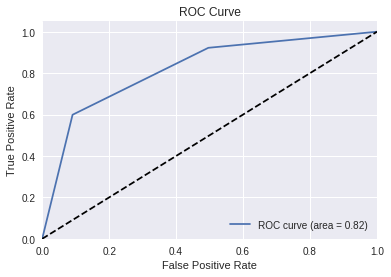

,score
precision,0.938 (+/- 0.033)
recall,0.627 (+/- 0.047)
f1,0.756 (+/- 0.032)
roc_auc,0.869 (+/- 0.012)


,test_score
precision,0.869
recall,0.599
f1,0.709
roc_auc,0.820


In [171]:
plot_roc_auc(y_test, y_pred_proba)
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [172]:
rf_bow_df = full_test_df.copy()

1    239
0    160
Name: y_pred, dtype: int64

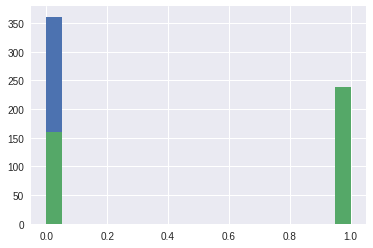

In [173]:
rf_bow_df[rf_bow_df.incoherence == 0].y_pred.hist(bins=20)
rf_bow_df[rf_bow_df.incoherence == 1].y_pred.hist(bins=20)
rf_bow_df[rf_bow_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

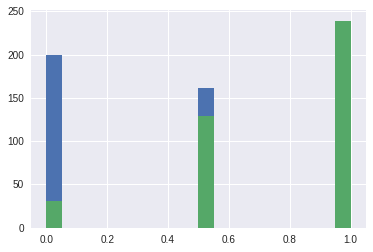

In [174]:
rf_bow_df[rf_bow_df.incoherence == 0].y_pred_proba.hist(bins=20)
rf_bow_df[rf_bow_df.incoherence == 1].y_pred_proba.hist(bins=20)

In [175]:
rf_bow_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][rf_bow_df.y_test==1].sort_values('y_pred_proba', ascending=True)
rf_bow_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(rf_bow_df.y_test == 1)&(rf_bow_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
idx_list = rf_bow_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(rf_bow_df.y_test == 1)&(rf_bow_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False).index.values.tolist()

#for i in idx_list:
#    print(rf_bow_df.loc[i,'string'],'\n')
    
#for id_subset in rf_bow_df.sample_id[(rf_bow_df.y_test == 1)&(rf_bow_df.y_pred == 1)].tolist():
#    print('comparison link:', '\t', 'https://fr.wikipedia.org/w/index.php?diff=' + str(df_XY.id[df_XY.sample_id==id_subset].values[0])+'&oldid='+str(int(df_XY.parentid[df_XY.sample_id==id_subset].values[0])),'\n')

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
248,from : howarth @ sbctri . sbc . com ( david ho...,1,1,0,0.0,767.0,172.0
603,from : ballb @ reis56 . alleg . edu ( brett ba...,1,1,0,0.0,2239.0,500.0
332,from : golf @ phoenix . oulu . fi ( jouko kylm...,1,1,0,0.0,431.0,145.0
432,from : htilney @ vax . clarku . edu subject : ...,1,1,0,0.0,370.0,82.0
202,from : maszakj @ pell1l5 . alleg . edu ( jonat...,1,1,0,0.0,1380.0,310.0
53,from : coulman @ cs . usask . ca ( randy coulm...,1,1,0,0.0,9444.0,3370.0
403,from : leventhal @ cs . bgsu . edu ( laura lev...,1,1,0,0.0,432.0,78.0
160,from : mblumens @ itsmail1 . hamilton . edu ( ...,1,1,0,0.0,948.0,243.0
196,from : aubin @ ccu . umanitoba . ca ( jean pau...,1,1,0,0.0,370.0,84.0
354,from : slutsky @ tesla . njit . edu subject : ...,1,1,0,0.0,461.0,91.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
2,from : co398 @ cleveland . freenet . edu ( the...,1,1,1,1.0,1005.0,246.0
521,from : phoenix @ startide . ctr . columbia . e...,1,1,1,1.0,2515.0,579.0
486,from : maynard @ ramsey . cs . laurentian . ca...,1,1,1,1.0,1196.0,260.0
490,from : icop @ csa . bu . edu ( antonio pera ) ...,1,1,1,1.0,697.0,148.0
492,from : hunter @ nsslsun . nssl . uoknor . edu ...,1,1,1,1.0,1061.0,229.0
493,from : golchowy @ alchemy . chem . utoronto . ...,1,1,1,1.0,1274.0,272.0
496,from : dvb @ ick ( david van beveren ) subject...,1,1,1,1.0,888.0,209.0
497,from : farenebt @ logic . camp . clarkson . ed...,1,1,1,1.0,2249.0,425.0
498,from : colling @ ann - arbor . applicon . slb ...,1,1,1,1.0,426.0,100.0
500,from : hammerl @ acsu . buffalo . edu ( valeri...,1,1,1,1.0,2947.0,654.0


Mean length of detected positive scores (character-wise and token-wise)

In [176]:
rf_bow_df.len[(rf_bow_df.y_test == 1)&(rf_bow_df.y_pred == 1)].mean()
rf_bow_df.len_tok[(rf_bow_df.y_test == 1)&(rf_bow_df.y_pred == 1)].mean()

1829.192468619247

450.5271966527197

## Method 2: TF-IDF

In [76]:
%%time
#vectorizer = TfidfVectorizer(max_features=4096)
#vectorizer.fit(txt_input)
##pickle.dump(vectorizer, open("vectorizer_tfidf.p", "wb"))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.1 µs


In [ ]:
#vectorizer = pickle.load(open("vectorizer_tfidf.p", "rb"))

In [ ]:
'''
print('Voc length: {:,}'.format(len(vectorizer.vocabulary_)))

X_train = vectorizer.transform(df_train.string).toarray()
X_test = vectorizer.transform(df_test.string).toarray()

y_train = df_train.incoherence.values
y_test = df_test.incoherence.values
'''

In [177]:
#### news
vectorizer = TfidfVectorizer(max_features=4096)
vectorizer.fit_transform(newsgroups_full.data)
print('Voc length: {:,}'.format(len(vectorizer.vocabulary_))) 
X_train = vectorizer.transform(df_train.string).toarray()
X_test = vectorizer.transform(df_test.string).toarray()

y_train = df_train.incoherence.values.copy()
y_test = df_test.incoherence.values.copy()

<11314x4096 sparse matrix of type '<class 'numpy.float64'>'
	with 1305225 stored elements in Compressed Sparse Row format>

Voc length: 4,096


#### Logistic Regression classifier

In [178]:
clf = LogisticRegression(solver='sag', n_jobs=-1, C=0.0000001) #,  The ‘newton-cg’, ‘sag’ and ‘lbfgs’ solvers support only l2 penalties.
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test = model_testing(X_train, y_train, X_test, y_test, clf)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


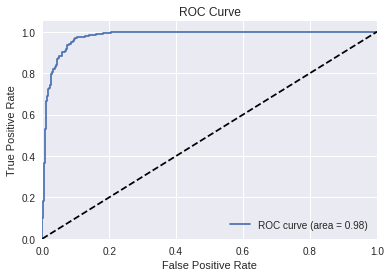

,score
precision,0.501 (+/- 0.149)
recall,1.000 (+/- 0.000)
f1,0.668 (+/- 0.001)
roc_auc,0.992 (+/- 0.004)


,test_score
precision,0.501
recall,1.000
f1,0.668
roc_auc,0.978


In [179]:
plot_roc_auc(y_test, y_pred_proba)
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [180]:
logreg_tfidf_df = full_test_df.copy()

1    399
Name: y_pred, dtype: int64

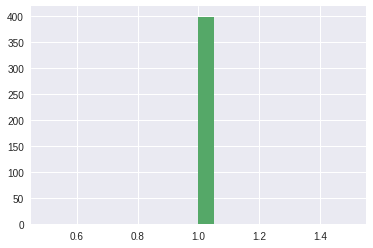

In [181]:
logreg_tfidf_df[logreg_tfidf_df.y_test == 0].y_pred.hist(bins=20)
logreg_tfidf_df[logreg_tfidf_df.y_test == 1].y_pred.hist(bins=20)
logreg_tfidf_df[logreg_tfidf_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

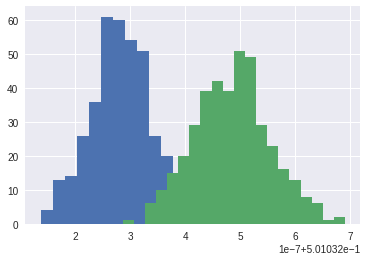

In [182]:
logreg_tfidf_df[logreg_tfidf_df.y_test == 0].y_pred_proba.hist(bins=20)
logreg_tfidf_df[logreg_tfidf_df.y_test == 1].y_pred_proba.hist(bins=20)

Display scores and detected positive samples

In [183]:
logreg_tfidf_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][logreg_tfidf_df.y_test==1].sort_values('y_pred_proba', ascending=False)
logreg_tfidf_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(logreg_tfidf_df.y_test == 1)&(logreg_tfidf_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
idx_list = logreg_tfidf_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(logreg_tfidf_df.y_test == 1)&(logreg_tfidf_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False).index.values.tolist()
#for i in idx_list:
#    print(logreg_tfidf_df.loc[i,'string'],'\n')
    
#for id_subset in logreg_tfidf_df.sample_id[(logreg_tfidf_df.y_test == 1)&(logreg_tfidf_df.y_pred == 1)].tolist():
#    print('comparison link:', '\t', 'https://fr.wikipedia.org/w/index.php?diff=' + str(df_XY.id[df_XY.sample_id==id_subset].values[0])+'&oldid='+str(int(df_XY.parentid[df_XY.sample_id==id_subset].values[0])),'\n')

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
52,from : v128r82w @ ubvmsd . cc . buffalo . edu ...,1,1,1,0.501033,2130.0,621.0
458,from : jpc @ philabs . philips . com ( john p ...,1,1,1,0.501033,5502.0,1705.0
521,from : phoenix @ startide . ctr . columbia . e...,1,1,1,0.501033,2515.0,579.0
677,from : golchowy @ alchemy . chem . utoronto . ...,1,1,1,0.501033,1802.0,389.0
742,from : bks2 @ cbnewsi . cb . att . com ( bryan...,1,1,1,0.501033,4197.0,1385.0
113,from : c5ff @ jupiter . sun . csd . unb . ca (...,1,1,1,0.501033,3786.0,1152.0
676,from : 35002_2765 @ uwovax . uwo . ca subject ...,1,1,1,0.501033,975.0,220.0
395,organization : university of maine system from...,1,1,1,0.501033,769.0,191.0
182,from : farenebt @ craft . camp . clarkson . ed...,1,1,1,0.501033,1337.0,219.0
451,from : bks2 @ cbnewsi . cb . att . com ( bryan...,1,1,1,0.501033,4129.0,1345.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
52,from : v128r82w @ ubvmsd . cc . buffalo . edu ...,1,1,1,0.501033,2130.0,621.0
458,from : jpc @ philabs . philips . com ( john p ...,1,1,1,0.501033,5502.0,1705.0
521,from : phoenix @ startide . ctr . columbia . e...,1,1,1,0.501033,2515.0,579.0
677,from : golchowy @ alchemy . chem . utoronto . ...,1,1,1,0.501033,1802.0,389.0
742,from : bks2 @ cbnewsi . cb . att . com ( bryan...,1,1,1,0.501033,4197.0,1385.0
113,from : c5ff @ jupiter . sun . csd . unb . ca (...,1,1,1,0.501033,3786.0,1152.0
676,from : 35002_2765 @ uwovax . uwo . ca subject ...,1,1,1,0.501033,975.0,220.0
395,organization : university of maine system from...,1,1,1,0.501033,769.0,191.0
182,from : farenebt @ craft . camp . clarkson . ed...,1,1,1,0.501033,1337.0,219.0
451,from : bks2 @ cbnewsi . cb . att . com ( bryan...,1,1,1,0.501033,4129.0,1345.0


Mean length of detected positive scores (character-wise and token-wise)

In [184]:
logreg_tfidf_df.len[(dt_bow_df.y_test == 1)&(logreg_tfidf_df.y_pred == 1)].mean()
logreg_tfidf_df.len_tok[(dt_bow_df.y_test == 1)&(logreg_tfidf_df.y_pred == 1)].mean()

1679.5513784461152

410.8922305764411

#### Decision tree classifier

In [185]:
clf = DecisionTreeClassifier(criterion='entropy', splitter='random')
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test = model_testing(X_train, y_train, X_test, y_test, clf)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

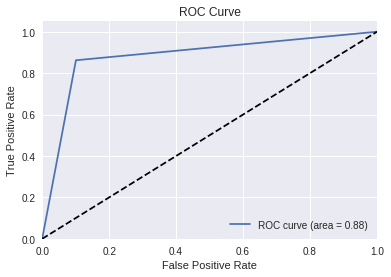

,score
precision,0.898 (+/- 0.032)
recall,0.872 (+/- 0.019)
f1,0.881 (+/- 0.025)
roc_auc,0.890 (+/- 0.018)


,test_score
precision,0.896
recall,0.862
f1,0.879
roc_auc,0.881


In [186]:
plot_roc_auc(y_test, y_pred_proba)
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [187]:
dt_tfidf_df = full_test_df.copy()

1    344
0     55
Name: y_pred, dtype: int64

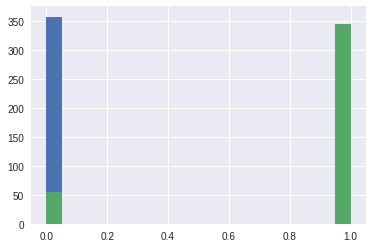

In [188]:
dt_tfidf_df[dt_tfidf_df.incoherence == 0].y_pred.hist(bins=20)
dt_tfidf_df[dt_tfidf_df.incoherence == 1].y_pred.hist(bins=20)
dt_tfidf_df[dt_tfidf_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

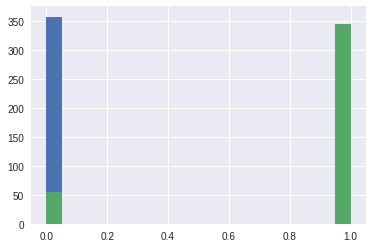

In [189]:
dt_tfidf_df[dt_tfidf_df.incoherence == 0].y_pred_proba.hist(bins=20)
dt_tfidf_df[dt_tfidf_df.incoherence == 1].y_pred_proba.hist(bins=20)

Display scores and detected positive samples

In [190]:
dt_tfidf_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][dt_tfidf_df.y_test==1].sort_values('y_pred_proba', ascending=False)
dt_tfidf_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(dt_tfidf_df.y_test == 1)&(dt_tfidf_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
idx_list = dt_tfidf_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(dt_tfidf_df.y_test == 1)&(dt_tfidf_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False).index.values.tolist()
#for i in idx_list:
#    print(dt_tfidf_df.loc[i,'string'],'\n')
    
#for id_subset in dt_tfidf_df.sample_id[(dt_tfidf_df.y_test == 1)&(dt_tfidf_df.y_pred == 1)].tolist():
#    print('comparison link:', '\t', 'https://fr.wikipedia.org/w/index.php?diff=' + str(df_XY.id[df_XY.sample_id==id_subset].values[0])+'&oldid='+str(int(df_XY.parentid[df_XY.sample_id==id_subset].values[0])),'\n')

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
2,from : co398 @ cleveland . freenet . edu ( the...,1,1,1,1.0,1005.0,246.0
493,from : golchowy @ alchemy . chem . utoronto . ...,1,1,1,1.0,1274.0,272.0
509,subject : makarov from : caldwell8102 @ mtroya...,1,1,1,1.0,1840.0,385.0
508,from : lmarsha @ cms . cc . wayne . edu ( laur...,1,1,1,1.0,1105.0,247.0
505,from : etxonss @ ufsa . ericsson . se ( staffa...,1,1,1,1.0,2435.0,746.0
504,from : boudreau @ athena . mit . edu ( carol v...,1,1,1,1.0,2271.0,583.0
502,"from : "" william k . willis "" < ww1a + @ andre...",1,1,1,1.0,496.0,109.0
500,from : hammerl @ acsu . buffalo . edu ( valeri...,1,1,1,1.0,2947.0,654.0
498,from : colling @ ann - arbor . applicon . slb ...,1,1,1,1.0,426.0,100.0
497,from : farenebt @ logic . camp . clarkson . ed...,1,1,1,1.0,2249.0,425.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
2,from : co398 @ cleveland . freenet . edu ( the...,1,1,1,1.0,1005.0,246.0
511,from : rskirsky @ athena . qualcomm . com ( ra...,1,1,1,1.0,604.0,136.0
532,from : klaty @ procyon . engin . umich . edu (...,1,1,1,1.0,717.0,150.0
531,from : jwh @ sei . cmu . edu ( john huber ) su...,1,1,1,1.0,2007.0,444.0
526,from : paul @ fugu . data - io . com ( paul br...,1,1,1,1.0,670.0,154.0
524,from : kfrank @ magnus . acs . ohio - state . ...,1,1,1,1.0,725.0,159.0
522,from : yadallee @ ersys . edmonton . ab . ca (...,1,1,1,1.0,2007.0,412.0
521,from : phoenix @ startide . ctr . columbia . e...,1,1,1,1.0,2515.0,579.0
519,from : farenebt @ craft . camp . clarkson . ed...,1,1,1,1.0,2131.0,363.0
518,from : nhmas @ gauss . med . harvard . edu ( m...,1,1,1,1.0,1606.0,366.0


Mean length of detected positive scores (character-wise and token-wise)

In [191]:
dt_tfidf_df.len[(dt_tfidf_df.y_test == 1)&(dt_tfidf_df.y_pred == 1)].mean()
dt_tfidf_df.len_tok[(dt_tfidf_df.y_test == 1)&(dt_tfidf_df.y_pred == 1)].mean()

1726.671511627907

422.40697674418607

## Method 3: Mean vectors

Function for getting mean vector of each string

In [192]:
def w2v_extractor(df, model):
    
    token_list = []
    sentence_list = []
    
    for i in range(0, df.shape[0]): # for each string
        g = 0
        for token in re.findall(string_pattern, df.loc[i,'string']): # for each token of the string
            g += 1
            if token in model.wv.vocab:
                token_list.append(np.reshape(model.wv.word_vec(token), (1, model.vector_size)))
                
            else:
                continue
        
        string_matrix = np.vstack(token_list)
        
        string_average = string_matrix.mean(axis=0)
        
        sentence_list.append(string_average)
        token_list = []
    
    string_ave_matrix = np.vstack(sentence_list)
    
    list_col = [] # generate columns labels for each of the dimensions
    for i in range(0, model.vector_size):
        list_col.append('dim_{}'.format(i))

    dim_df = pd.DataFrame(string_ave_matrix)
    dim_df.columns = list_col
    
    return dim_df

### 3.1 Vector size 100

In [193]:
#model = Word2Vec.load('/media/hdd/sileo/wiki-fr/text/full_filtered_language_model_100')
model = Word2Vec.load('/media/hdd/sileo/wiki-fr/text/language_model_newsgroups100')
dim_df_train = w2v_extractor(df_train, model)
dim_df_test = w2v_extractor(df_test, model)

temp_df_train = pd.concat([df_train.copy(), dim_df_train], axis=1)
temp_df_test = pd.concat([df_test.copy(), dim_df_test], axis=1)

X_train = temp_df_train[temp_df_train.columns[-model.vector_size:]].values.copy()
X_test = temp_df_test[temp_df_test.columns[-model.vector_size:]].values.copy()

y_train = temp_df_train.incoherence.values.copy()
y_test = temp_df_test.incoherence.values.copy()

#### Logistic regression

In [194]:
clf = LogisticRegression(solver='sag', n_jobs=-1, C=0.000000001)
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/class

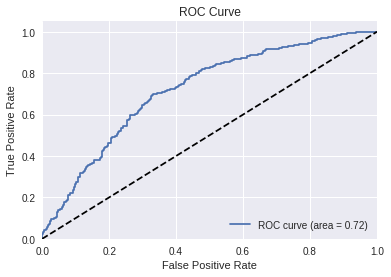

100

,score
precision,0.168 (+/- 0.200)
recall,0.505 (+/- 0.377)
f1,0.334 (+/- 0.252)
roc_auc,0.724 (+/- 0.025)


,test_score
precision,0.501
recall,1.000
f1,0.668
roc_auc,0.719


In [195]:
plot_roc_auc(y_test, y_pred_proba)
model.vector_size
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [196]:
logreg100_mean_df = full_test_df.copy()

1    399
Name: y_pred, dtype: int64

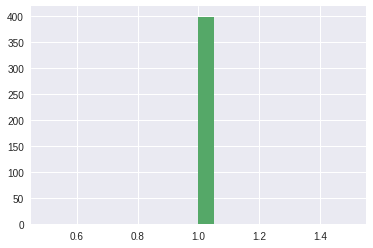

In [197]:
logreg100_mean_df[logreg100_mean_df.y_test == 0].y_pred.hist(bins=20)
logreg100_mean_df[logreg100_mean_df.y_test == 1].y_pred.hist(bins=20)
logreg100_mean_df[logreg100_mean_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

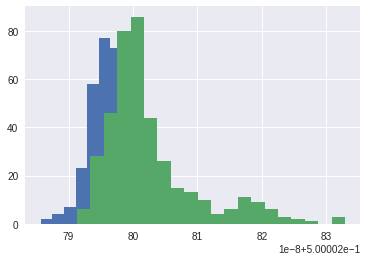

In [198]:
logreg100_mean_df[logreg100_mean_df.y_test == 0].y_pred_proba.hist(bins=20)
logreg100_mean_df[logreg100_mean_df.y_test == 1].y_pred_proba.hist(bins=20)

Display scores and detected positive samples

In [199]:
logreg100_mean_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][logreg100_mean_df.y_test==1].sort_values('y_pred_proba', ascending=False)
logreg100_mean_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(logreg100_mean_df.y_test == 1)&(logreg100_mean_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
idx_list = logreg100_mean_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(logreg100_mean_df.y_test == 1)&(logreg100_mean_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False).index.values.tolist()
#for i in idx_list:
#    print(logreg100_mean_df.loc[i,'string'],'\n')
    
#for id_subset in logreg100_mean_df.sample_id[(logreg100_mean_df.y_test == 1)&(logreg100_mean_df.y_pred == 1)].tolist():
#    print('comparison link:', '\t', 'https://fr.wikipedia.org/w/index.php?diff=' + str(df_XY.id[df_XY.sample_id==id_subset].values[0])+'&oldid='+str(int(df_XY.parentid[df_XY.sample_id==id_subset].values[0])),'\n')

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
609,from : huot @ cray . com ( tom huot ) subject ...,1,1,1,0.500003,1002.0,324.0
171,from : e8l6 @ jupiter . sun . csd . unb . ca (...,1,1,1,0.500003,8260.0,2842.0
21,from : huot @ cray . com ( tom huot ) subject ...,1,1,1,0.500003,1003.0,335.0
15,from : admiral @ jhunix . hcf . jhu . edu ( st...,1,1,1,0.500003,1583.0,444.0
235,from : jca2 @ cec1 . wustl . edu ( joseph char...,1,1,1,0.500003,2725.0,1052.0
101,from : jca2 @ cec1 . wustl . edu ( joseph char...,1,1,1,0.500003,5992.0,2171.0
79,from : gld @ cunixb . cc . columbia . edu ( ga...,1,1,1,0.500003,820.0,229.0
187,from : huot @ cray . com ( tom huot ) subject ...,1,1,1,0.500003,1583.0,454.0
716,from : jca2 @ cec1 . wustl . edu ( joseph char...,1,1,1,0.500003,1393.0,491.0
578,from : jca2 @ cec1 . wustl . edu ( joseph char...,1,1,1,0.500003,1357.0,486.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
609,from : huot @ cray . com ( tom huot ) subject ...,1,1,1,0.500003,1002.0,324.0
171,from : e8l6 @ jupiter . sun . csd . unb . ca (...,1,1,1,0.500003,8260.0,2842.0
21,from : huot @ cray . com ( tom huot ) subject ...,1,1,1,0.500003,1003.0,335.0
15,from : admiral @ jhunix . hcf . jhu . edu ( st...,1,1,1,0.500003,1583.0,444.0
235,from : jca2 @ cec1 . wustl . edu ( joseph char...,1,1,1,0.500003,2725.0,1052.0
101,from : jca2 @ cec1 . wustl . edu ( joseph char...,1,1,1,0.500003,5992.0,2171.0
79,from : gld @ cunixb . cc . columbia . edu ( ga...,1,1,1,0.500003,820.0,229.0
187,from : huot @ cray . com ( tom huot ) subject ...,1,1,1,0.500003,1583.0,454.0
716,from : jca2 @ cec1 . wustl . edu ( joseph char...,1,1,1,0.500003,1393.0,491.0
578,from : jca2 @ cec1 . wustl . edu ( joseph char...,1,1,1,0.500003,1357.0,486.0


#### Decision tree classifier

In [200]:
clf = DecisionTreeClassifier()
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

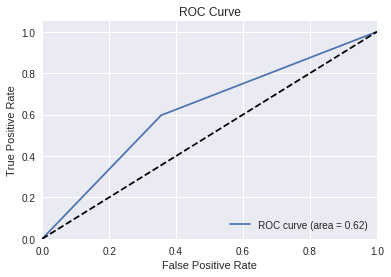

100

,score
precision,0.681 (+/- 0.034)
recall,0.665 (+/- 0.018)
f1,0.676 (+/- 0.038)
roc_auc,0.671 (+/- 0.018)


,test_score
precision,0.628
recall,0.596
f1,0.612
roc_auc,0.621


In [201]:
plot_roc_auc(y_test, y_pred_proba)
model.vector_size
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [202]:
dt100_mean_df = full_test_df.copy()

1    238
0    161
Name: y_pred, dtype: int64

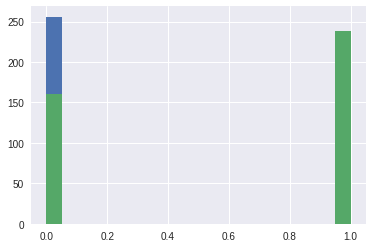

In [203]:
dt100_mean_df[dt100_mean_df.y_test == 0].y_pred.hist(bins=20)
dt100_mean_df[dt100_mean_df.y_test == 1].y_pred.hist(bins=20)
dt100_mean_df[dt100_mean_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

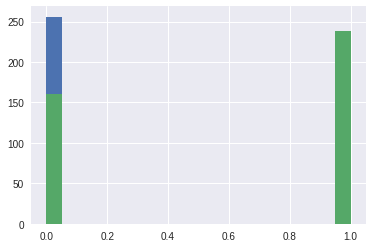

In [204]:
dt100_mean_df[dt100_mean_df.y_test == 0].y_pred_proba.hist(bins=20)
dt100_mean_df[dt100_mean_df.y_test == 1].y_pred_proba.hist(bins=20)

Display scores and detected positive samples

In [205]:
dt100_mean_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][dt100_mean_df.y_test==1].sort_values('y_pred_proba', ascending=False)
dt100_mean_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(dt100_mean_df.y_test == 1)&(dt100_mean_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
idx_list = dt100_mean_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(dt100_mean_df.y_test == 1)&(dt100_mean_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False).index.values.tolist()
#for i in idx_list:
#    print(dt100_mean_df.loc[i,'string'],'\n')
    
#for id_subset in dt100_mean_df.sample_id[(dt100_mean_df.y_test == 1)&(dt100_mean_df.y_pred == 1)].tolist():
#    print('comparison link:', '\t', 'https://fr.wikipedia.org/w/index.php?diff=' + str(df_XY.id[df_XY.sample_id==id_subset].values[0])+'&oldid='+str(int(df_XY.parentid[df_XY.sample_id==id_subset].values[0])),'\n')

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
382,from : chuq @ apple . com ( chuq von rospach )...,1,1,1,1.0,1220.0,278.0
400,from : gomer + @ pitt . edu ( richard j coyle ...,1,1,1,1.0,1133.0,241.0
338,from : mre @ teal . eng . sun . com ( mike eis...,1,1,1,1.0,4651.0,1036.0
650,from : umturne4 @ ccu . umanitoba . ca ( daryl...,1,1,1,1.0,4276.0,1026.0
340,from : neath @ brazil . psych . purdue . edu (...,1,1,1,1.0,1349.0,285.0
649,from : galvint @ cs . nps . navy . mil ( thoma...,1,1,1,1.0,1830.0,379.0
348,subject : more hart trophy stuff . . . . from ...,1,1,1,1.0,1203.0,260.0
349,from : maynard @ ramsey . cs . laurentian . ca...,1,1,1,1.0,3714.0,796.0
351,from : yadalle @ cs . ualberta . ca ( yadallee...,1,1,1,1.0,1481.0,333.0
353,subject : re : nhl team captains from : caldwe...,1,1,1,1.0,550.0,112.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
4,from : wihervaa @ messi . uku . fi ( mikko wih...,1,1,1,1.0,1421.0,309.0
541,from : farenebt @ craft . camp . clarkson . ed...,1,1,1,1.0,1711.0,398.0
500,from : hammerl @ acsu . buffalo . edu ( valeri...,1,1,1,1.0,2947.0,654.0
502,"from : "" william k . willis "" < ww1a + @ andre...",1,1,1,1.0,496.0,109.0
505,from : etxonss @ ufsa . ericsson . se ( staffa...,1,1,1,1.0,2435.0,746.0
508,from : lmarsha @ cms . cc . wayne . edu ( laur...,1,1,1,1.0,1105.0,247.0
509,subject : makarov from : caldwell8102 @ mtroya...,1,1,1,1.0,1840.0,385.0
511,from : rskirsky @ athena . qualcomm . com ( ra...,1,1,1,1.0,604.0,136.0
522,from : yadallee @ ersys . edmonton . ab . ca (...,1,1,1,1.0,2007.0,412.0
524,from : kfrank @ magnus . acs . ohio - state . ...,1,1,1,1.0,725.0,159.0


### 3.2 Vector size 300

In [206]:
#model = Word2Vec.load('/media/hdd/sileo/wiki-fr/text/full_filtered_language_model_300')
model = Word2Vec.load('/media/hdd/sileo/wiki-fr/text/language_model_newsgroups300')
dim_df_train = w2v_extractor(df_train, model)
dim_df_test = w2v_extractor(df_test, model)

temp_df_train = pd.concat([df_train.copy(), dim_df_train], axis=1)
temp_df_test = pd.concat([df_test.copy(), dim_df_test], axis=1)

X_train = temp_df_train[temp_df_train.columns[-model.vector_size:]].values.copy()
X_test = temp_df_test[temp_df_test.columns[-model.vector_size:]].values.copy()

y_train = temp_df_train.incoherence.values.copy()
y_test = temp_df_test.incoherence.values.copy()

#### Logistic regression

In [207]:
clf = LogisticRegression(solver='sag', n_jobs=-1, C=0.000000001)
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classif

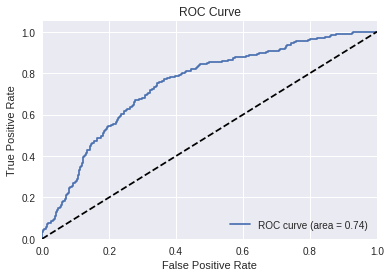

300

,score
precision,0.335 (+/- 0.001)
recall,0.667 (+/- 0.298)
f1,0.556 (+/- 0.267)
roc_auc,0.729 (+/- 0.040)


,test_score
precision,0.501
recall,1.000
f1,0.668
roc_auc,0.744


In [208]:
plot_roc_auc(y_test, y_pred_proba)
model.vector_size
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [209]:
logreg300_mean_df = full_test_df.copy()

1    399
Name: y_pred, dtype: int64

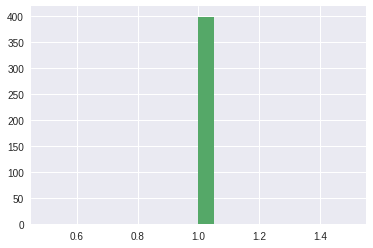

In [210]:
logreg300_mean_df[logreg300_mean_df.y_test == 0].y_pred.hist(bins=20)
logreg300_mean_df[logreg300_mean_df.y_test == 1].y_pred.hist(bins=20)
logreg300_mean_df[logreg300_mean_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

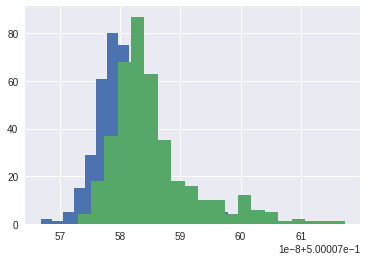

In [211]:
logreg300_mean_df[logreg300_mean_df.y_test == 0].y_pred_proba.hist(bins=20)
logreg300_mean_df[logreg300_mean_df.y_test == 1].y_pred_proba.hist(bins=20)

Display scores and detected positive samples

In [213]:
logreg300_mean_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][logreg300_mean_df.y_test==1].sort_values('y_pred_proba', ascending=True)
logreg300_mean_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(logreg300_mean_df.y_test == 1)&(logreg300_mean_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
idx_list = logreg300_mean_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(logreg300_mean_df.y_test == 1)&(logreg300_mean_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False).index.values.tolist()
#for i in idx_list:
#    print(logreg300_mean_df.loc[i,'string'],'\n')
    
#for id_subset in logreg300_mean_df.sample_id[(logreg300_mean_df.y_test == 1)&(logreg300_mean_df.y_pred == 1)].tolist():
#    print('comparison link:', '\t', 'https://fr.wikipedia.org/w/index.php?diff=' + str(df_XY.id[df_XY.sample_id==id_subset].values[0])+'&oldid='+str(int(df_XY.parentid[df_XY.sample_id==id_subset].values[0])),'\n')

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
476,from : hammerl @ acsu . buffalo . edu ( valeri...,1,1,1,0.500008,1271.0,297.0
333,from : gwittt @ alleg . edu ( tom gwitt ) subj...,1,1,1,0.500008,560.0,127.0
264,from : jake @ rambler . eng . sun . com ( jaso...,1,1,1,0.500008,430.0,99.0
318,from : archer @ elysium . esd . sgi . com ( ar...,1,1,1,0.500008,955.0,212.0
297,subject : re : wings news and playoff thoughts...,1,1,1,0.500008,720.0,163.0
339,from : msanfrat @ cs . ucsd . edu ( mike sanfr...,1,1,1,0.500008,513.0,142.0
500,from : hammerl @ acsu . buffalo . edu ( valeri...,1,1,1,0.500008,2947.0,654.0
557,from : gwittt @ alleg . edu ( tom gwitt ) subj...,1,1,1,0.500008,537.0,126.0
553,organization : queen ' s university at kingsto...,1,1,1,0.500008,844.0,192.0
747,from : lmarsha @ cms . cc . wayne . edu ( laur...,1,1,1,0.500008,705.0,166.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
171,from : e8l6 @ jupiter . sun . csd . unb . ca (...,1,1,1,0.500008,8260.0,2842.0
609,from : huot @ cray . com ( tom huot ) subject ...,1,1,1,0.500008,1002.0,324.0
21,from : huot @ cray . com ( tom huot ) subject ...,1,1,1,0.500008,1003.0,335.0
235,from : jca2 @ cec1 . wustl . edu ( joseph char...,1,1,1,0.500008,2725.0,1052.0
101,from : jca2 @ cec1 . wustl . edu ( joseph char...,1,1,1,0.500008,5992.0,2171.0
15,from : admiral @ jhunix . hcf . jhu . edu ( st...,1,1,1,0.500008,1583.0,444.0
716,from : jca2 @ cec1 . wustl . edu ( joseph char...,1,1,1,0.500008,1393.0,491.0
366,from : farenebt @ craft . camp . clarkson . ed...,1,1,1,0.500008,2547.0,520.0
578,from : jca2 @ cec1 . wustl . edu ( joseph char...,1,1,1,0.500008,1357.0,486.0
79,from : gld @ cunixb . cc . columbia . edu ( ga...,1,1,1,0.500008,820.0,229.0


#### Decision Tree classifier

In [214]:
clf = DecisionTreeClassifier()
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

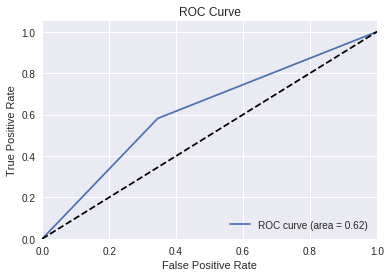

300

,score
precision,0.666 (+/- 0.031)
recall,0.663 (+/- 0.051)
f1,0.651 (+/- 0.028)
roc_auc,0.683 (+/- 0.020)


,test_score
precision,0.629
recall,0.581
f1,0.604
roc_auc,0.618


In [215]:
plot_roc_auc(y_test, y_pred_proba)
model.vector_size
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [216]:
dt300_mean_df = full_test_df.copy()

1    232
0    167
Name: y_pred, dtype: int64

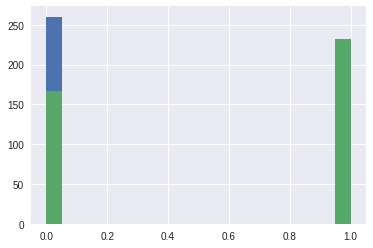

In [217]:
dt300_mean_df[dt300_mean_df.y_test == 0].y_pred.hist(bins=20)
dt300_mean_df[dt300_mean_df.y_test == 1].y_pred.hist(bins=20)
dt300_mean_df[dt300_mean_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

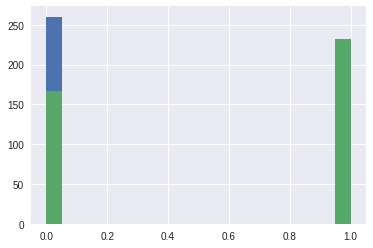

In [218]:
dt300_mean_df[dt300_mean_df.y_test == 0].y_pred_proba.hist(bins=20)
dt300_mean_df[dt300_mean_df.y_test == 1].y_pred_proba.hist(bins=20)

Display scores and detected positive samples

In [220]:
dt300_mean_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][dt300_mean_df.y_test==1].sort_values('y_pred_proba', ascending=True)
dt300_mean_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(dt300_mean_df.y_test == 1)&(dt300_mean_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
idx_list = dt300_mean_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(dt300_mean_df.y_test == 1)&(dt300_mean_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False).index.values.tolist()

#for i in idx_list:
#    print(dt300_mean_df.loc[i,'string'],'\n')
    
#for id_subset in dt300_mean_df.sample_id[(dt300_mean_df.y_test == 1)&(dt300_mean_df.y_pred == 1)].tolist():
#    print('comparison link:', '\t', 'https://fr.wikipedia.org/w/index.php?diff=' + str(df_XY.id[df_XY.sample_id==id_subset].values[0])+'&oldid='+str(int(df_XY.parentid[df_XY.sample_id==id_subset].values[0])),'\n')

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
795,from : chuq @ apple . com ( chuq von rospach )...,1,1,0,0.0,3525.0,767.0
280,from : yadalle @ cs . ualberta . ca ( yadallee...,1,1,0,0.0,693.0,152.0
285,from : joe13 + @ pitt . edu ( joseph b stiehm ...,1,1,0,0.0,1081.0,256.0
288,from : lmarsha @ cms . cc . wayne . edu ( laur...,1,1,0,0.0,1020.0,232.0
294,from : tmenner @ sei . cmu . edu ( thomas menn...,1,1,0,0.0,1187.0,221.0
603,from : ballb @ reis56 . alleg . edu ( brett ba...,1,1,0,0.0,2239.0,500.0
299,from : vergolin @ euler . lbs . msu . edu ( da...,1,1,0,0.0,631.0,131.0
301,from : reif @ sun8 . ruf . uni - freiburg . de...,1,1,0,0.0,665.0,209.0
304,from : drozinst @ db . erau . edu ( drozinski ...,1,1,0,0.0,3008.0,776.0
600,organization : penn state university from : ro...,1,1,0,0.0,867.0,200.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
2,from : co398 @ cleveland . freenet . edu ( the...,1,1,1,1.0,1005.0,246.0
531,from : jwh @ sei . cmu . edu ( john huber ) su...,1,1,1,1.0,2007.0,444.0
492,from : hunter @ nsslsun . nssl . uoknor . edu ...,1,1,1,1.0,1061.0,229.0
493,from : golchowy @ alchemy . chem . utoronto . ...,1,1,1,1.0,1274.0,272.0
497,from : farenebt @ logic . camp . clarkson . ed...,1,1,1,1.0,2249.0,425.0
498,from : colling @ ann - arbor . applicon . slb ...,1,1,1,1.0,426.0,100.0
502,"from : "" william k . willis "" < ww1a + @ andre...",1,1,1,1.0,496.0,109.0
505,from : etxonss @ ufsa . ericsson . se ( staffa...,1,1,1,1.0,2435.0,746.0
508,from : lmarsha @ cms . cc . wayne . edu ( laur...,1,1,1,1.0,1105.0,247.0
509,subject : makarov from : caldwell8102 @ mtroya...,1,1,1,1.0,1840.0,385.0


## Method 4: skig-gram model

In [221]:
def scores_generator(df_train, df_test, pair_fn):
    
    df_test_temp = df_test.copy()
    df_test_temp = df_test_temp.reset_index()

    df_scores = pd.DataFrame(index=df_train.index, columns=['score'])
    df_scores_test = pd.DataFrame(index=df_test_temp.index, columns=['score'])

    for i in range(0, df_train.shape[0]):
        df_scores.loc[i,'string'] = df_train.loc[i,'string']
        df_scores.loc[i,'score'] = score_sentence_sg(pair_fn, model, re.findall(string_pattern, df_train.loc[i,'string']))
        
    X_train = df_scores.score
    y_train = df_train.incoherence
    
    for i in range(0, df_test_temp.shape[0]):
        df_scores_test.loc[i,'string'] = df_test_temp.loc[i,'string']
        df_scores_test.loc[i,'score'] = score_sentence_sg(pair_fn, model, re.findall(string_pattern, df_test_temp.loc[i,'string']))
        
    X_test = df_scores_test.score
    y_test = df_test_temp.incoherence
    
    return df_scores, X_train, y_train, df_scores_test, X_test, y_test

In [222]:
def score_sentence_sg(score_sg_fn, model, sentence, work=None):
    """
    Obtain likelihood score for a single sentence in a fitted skip-gram representaion.

    The sentence is a list of Vocab objects (or None, when the corresponding
    word is not in the vocabulary). Called internally from `Word2Vec.score()`.

    This is the non-optimized, Python version. If you have cython installed, gensim
    will use the optimized version from word2vec_inner instead.
    
    """

    log_prob_sentence = 0.0
    if model.negative:
        raise RuntimeError("scoring is only available for HS=True")

    word_vocabs = [model.wv.vocab[w] for w in sentence if w in model.wv.vocab]
    for pos, word in enumerate(word_vocabs):
        if word is None:
            continue  # OOV word in the input sentence => skip

        # now go over all words from the window, predicting each one in turn
        start = max(0, pos - model.window)
        for pos2, word2 in enumerate(word_vocabs[start : pos + model.window + 1], start):
            # don't train on OOV words and on the `word` itself
            if word2 is not None and pos2 != pos:
                log_prob_sentence += score_sg_fn(model, word, word2)

    return log_prob_sentence


def score_sg_pair_original(model, word, word2):
    l1 = model.wv.syn0[word2.index]
    l2a = deepcopy(model.syn1[word.point])  # 2d matrix, codelen x layer1_size
    sgn = (-1.0)**word.code  # ch function, 0-> 1, 1 -> -1
    lprob = -np.log(1.0 + np.exp(-sgn*np.dot(l1, l2a.T)))
    return sum(lprob)

def score_sg_pair(model, word, word2):
    #print(word, word2)
    l1 = model.wv.syn0[word2.index]
    print('a >', word.point.shape, word.code.shape)
    l2 = deepcopy(model.syn1[word.point])  # 2d matrix, codelen x layer1_size

    #assert l1.shape == l2.shape
    lprob = l2 * l1
    print('b >', lprob.shape)
    return lprob

### 4.1 Vector size 100

In [223]:
#model = Word2Vec.load('/media/hdd/sileo/wiki-fr/text/full_filtered_language_model_100')
model = Word2Vec.load('/media/hdd/sileo/wiki-fr/text/language_model_newsgroups100')
df_scores, X_train, y_train, df_scores_test, X_test, y_test = scores_generator(df_train, df_test, score_sg_pair_original)
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)

/home/dp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.
/home/dp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """


#### Logistic regression

In [224]:
clf = LogisticRegression()
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

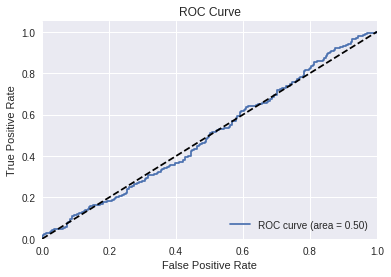

100

,score
precision,0.501 (+/- 0.001)
recall,1.000 (+/- 0.000)
f1,0.668 (+/- 0.001)
roc_auc,0.578 (+/- 0.055)


,test_score
precision,0.501
recall,1.000
f1,0.668
roc_auc,0.500


In [225]:
plot_roc_auc(y_test, y_pred_proba)
model.vector_size
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [226]:
logreg100_sg_df = full_test_df.copy()

1    399
Name: y_pred, dtype: int64

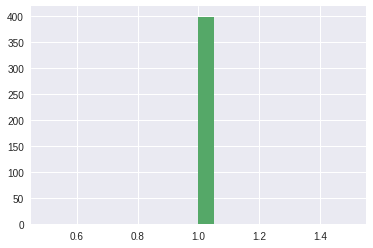

In [227]:
logreg100_sg_df[logreg100_sg_df.y_test == 0].y_pred.hist(bins=20)
logreg100_sg_df[logreg100_sg_df.y_test == 1].y_pred.hist(bins=20)
logreg100_sg_df[logreg100_sg_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

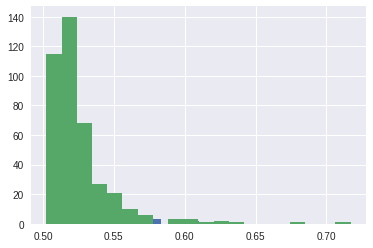

In [228]:
logreg100_sg_df[logreg100_sg_df.y_test == 0].y_pred_proba.hist(bins=20)
logreg100_sg_df[logreg100_sg_df.y_test == 1].y_pred_proba.hist(bins=20)

Display scores and detected positive samples

In [229]:
logreg100_sg_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][logreg100_sg_df.y_test==1].sort_values('y_pred_proba', ascending=True)
logreg100_sg_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(logreg100_sg_df.y_test == 1)&(logreg100_sg_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
idx_list = logreg100_sg_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(logreg100_sg_df.y_test == 1)&(logreg100_sg_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False).index.values.tolist()

#for i in idx_list:
#    print(logreg100_sg_df.loc[i,'string'],'\n')
    
#for id_subset in logreg100_sg_df.sample_id[(logreg100_sg_df.y_test == 1)&(logreg100_sg_df.y_pred == 1)].tolist():
#    print('comparison link:', '\t', 'https://fr.wikipedia.org/w/index.php?diff=' + str(df_XY.id[df_XY.sample_id==id_subset].values[0])+'&oldid='+str(int(df_XY.parentid[df_XY.sample_id==id_subset].values[0])),'\n')

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
471,from : anthonyp @ sco . com ( anthony picilaid...,1,1,1,0.502255,171.0,37.0
380,from : ballb @ carr113 . alleg . edu ( brett b...,1,1,1,0.502924,210.0,45.0
140,subject : binghampton rangers playoff games fr...,1,1,1,0.503411,296.0,53.0
51,from : rzuback @ alumni . lakeheadu . ca subje...,1,1,1,0.504113,279.0,60.0
762,from : rzuback @ alumni . lakeheadu . ca subje...,1,1,1,0.504270,299.0,66.0
793,from : golchowy @ alchemy . chem . utoronto . ...,1,1,1,0.504348,361.0,73.0
357,from : au021 @ cleveland . freenet . edu ( rol...,1,1,1,0.504852,350.0,78.0
73,"from : gjd4n @ virginia . edu ( "" gregory j . ...",1,1,1,0.504857,379.0,74.0
530,from : ua256 @ freenet . victoria . bc . ca ( ...,1,1,1,0.505370,364.0,81.0
403,from : leventhal @ cs . bgsu . edu ( laura lev...,1,1,1,0.505598,432.0,78.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
377,from : andrew @ idacom . hp . com ( andrew sco...,1,1,1,0.717152,13588.0,3988.0
453,from : gritter @ cs . purdue . edu ( carl grit...,1,1,1,0.679508,9539.0,2551.0
91,from : andrew @ idacom . hp . com ( andrew sco...,1,1,1,0.633550,5758.0,1386.0
171,from : e8l6 @ jupiter . sun . csd . unb . ca (...,1,1,1,0.626317,8260.0,2842.0
200,from : andrew @ idacom . hp . com ( andrew sco...,1,1,1,0.621187,6664.0,1761.0
53,from : coulman @ cs . usask . ca ( randy coulm...,1,1,1,0.618905,9444.0,3370.0
101,from : jca2 @ cec1 . wustl . edu ( joseph char...,1,1,1,0.607807,5992.0,2171.0
194,from : machnik @ ctron . com ( michael c . mac...,1,1,1,0.605452,6177.0,1701.0
307,from : jca2 @ cec1 . wustl . edu ( joseph char...,1,1,1,0.603665,6790.0,1618.0
360,from : coulman @ cs . usask . ca ( randy coulm...,1,1,1,0.594298,5441.0,1525.0


#### Decision tree classifier

In [230]:
clf = DecisionTreeClassifier(max_depth=1)#,criterion='entropy')#, splitter='random', class_weight='balanced')
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test = model_testing(X_train, y_train, X_test, y_test, clf)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

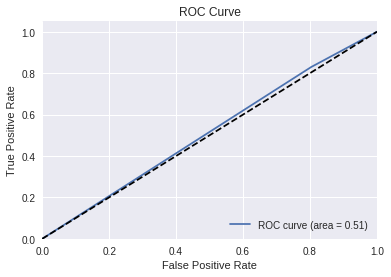

100

,score
precision,0.536 (+/- 0.008)
recall,0.728 (+/- 0.070)
f1,0.603 (+/- 0.021)
roc_auc,0.545 (+/- 0.020)


,test_score
precision,0.509
recall,0.830
f1,0.631
roc_auc,0.513


In [231]:
plot_roc_auc(y_test, y_pred_proba)
model.vector_size
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [232]:
dt100_sg_df = full_test_df.copy()

1    331
0     68
Name: y_pred, dtype: int64

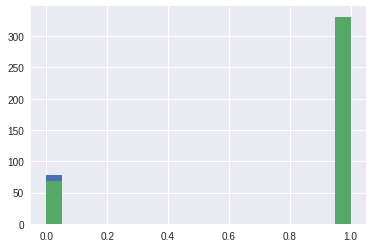

In [233]:
dt100_sg_df[dt100_sg_df.y_test == 0].y_pred.hist(bins=20)
dt100_sg_df[dt100_sg_df.y_test == 1].y_pred.hist(bins=20)
dt100_sg_df[dt100_sg_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

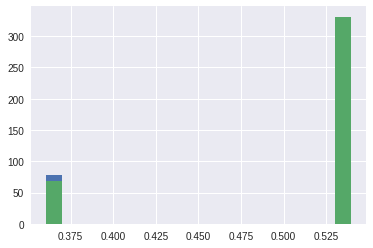

In [234]:
dt100_sg_df[dt100_sg_df.y_test == 0].y_pred_proba.hist(bins=20)
dt100_sg_df[dt100_sg_df.y_test == 1].y_pred_proba.hist(bins=20)

Display scores and detected positive samples

In [235]:
dt100_sg_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][dt100_sg_df.y_test==1].sort_values('y_pred_proba', ascending=False)
dt100_sg_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(dt100_sg_df.y_test == 1)&(dt100_sg_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
idx_list = dt100_sg_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(dt100_sg_df.y_test == 1)&(dt100_sg_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False).index.values.tolist()

#for i in idx_list:
#    print(dt100_sg_df.loc[i,'string'],'\n')
    
#for id_subset in dt100_sg_df.sample_id[(dt100_sg_df.y_test == 1)&(dt100_sg_df.y_pred == 1)].tolist():
#    print('comparison link:', '\t', 'https://fr.wikipedia.org/w/index.php?diff=' + str(df_XY.id[df_XY.sample_id==id_subset].values[0])+'&oldid='+str(int(df_XY.parentid[df_XY.sample_id==id_subset].values[0])),'\n')

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
2,from : co398 @ cleveland . freenet . edu ( the...,1,1,1,0.539278,1005.0,246.0
531,from : jwh @ sei . cmu . edu ( john huber ) su...,1,1,1,0.539278,2007.0,444.0
522,from : yadallee @ ersys . edmonton . ab . ca (...,1,1,1,0.539278,2007.0,412.0
521,from : phoenix @ startide . ctr . columbia . e...,1,1,1,0.539278,2515.0,579.0
519,from : farenebt @ craft . camp . clarkson . ed...,1,1,1,0.539278,2131.0,363.0
518,from : nhmas @ gauss . med . harvard . edu ( m...,1,1,1,0.539278,1606.0,366.0
509,subject : makarov from : caldwell8102 @ mtroya...,1,1,1,0.539278,1840.0,385.0
508,from : lmarsha @ cms . cc . wayne . edu ( laur...,1,1,1,0.539278,1105.0,247.0
505,from : etxonss @ ufsa . ericsson . se ( staffa...,1,1,1,0.539278,2435.0,746.0
504,from : boudreau @ athena . mit . edu ( carol v...,1,1,1,0.539278,2271.0,583.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
2,from : co398 @ cleveland . freenet . edu ( the...,1,1,1,0.539278,1005.0,246.0
552,from : steven . kipling @ freddy . ersys . edm...,1,1,1,0.539278,1036.0,249.0
548,from : leunggm @ odin . control . utoronto . c...,1,1,1,0.539278,2757.0,601.0
545,organization : penn state university from : ro...,1,1,1,0.539278,1705.0,438.0
543,"from : "" carl d . lovejoy "" < cl3d + @ andrew ...",1,1,1,0.539278,1252.0,280.0
541,from : farenebt @ craft . camp . clarkson . ed...,1,1,1,0.539278,1711.0,398.0
538,from : anna matyas < am2x + @ andrew . cmu . e...,1,1,1,0.539278,2173.0,496.0
536,from : joe13 + @ pitt . edu ( joseph b stiehm ...,1,1,1,0.539278,1748.0,391.0
533,from : allan @ cs . ualberta . ca ( allan sull...,1,1,1,0.539278,1365.0,265.0
532,from : klaty @ procyon . engin . umich . edu (...,1,1,1,0.539278,717.0,150.0


### 4.2 Vector size 300

In [236]:
#model = Word2Vec.load('/media/hdd/sileo/wiki-fr/text/full_filtered_language_model_300')
model = Word2Vec.load('/media/hdd/sileo/wiki-fr/text/language_model_newsgroups300')
df_scores, X_train, y_train, df_scores_test, X_test, y_test = scores_generator(df_train, df_test, score_sg_pair_original)
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)

/home/dp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.
/home/dp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """


#### Logistic regression

In [237]:
clf = LogisticRegression()
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

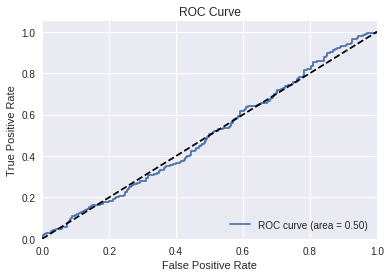

300

,score
precision,0.501 (+/- 0.001)
recall,1.000 (+/- 0.000)
f1,0.668 (+/- 0.001)
roc_auc,0.578 (+/- 0.030)


,test_score
precision,0.501
recall,1.000
f1,0.668
roc_auc,0.500


In [238]:
plot_roc_auc(y_test, y_pred_proba)
model.vector_size
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [239]:
logreg300_sg_df = full_test_df.copy()

1    399
Name: y_pred, dtype: int64

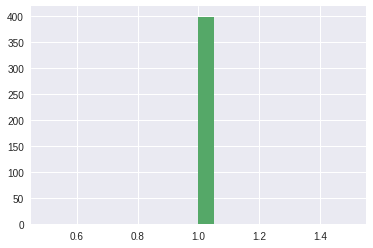

In [240]:
logreg300_sg_df[logreg300_sg_df.y_test == 0].y_pred.hist(bins=20)
logreg300_sg_df[logreg300_sg_df.y_test == 1].y_pred.hist(bins=20)
logreg300_sg_df[logreg300_sg_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

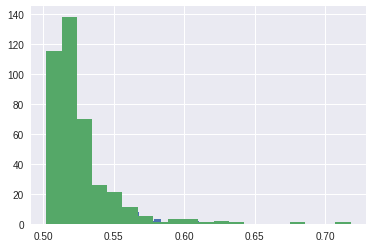

In [241]:
logreg300_sg_df[logreg300_sg_df.y_test == 0].y_pred_proba.hist(bins=20)
logreg300_sg_df[logreg300_sg_df.y_test == 1].y_pred_proba.hist(bins=20)

Display scores and detected positive samples

In [242]:
logreg300_sg_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][logreg300_sg_df.y_test==1].sort_values('y_pred_proba', ascending=False)
logreg300_sg_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(logreg300_sg_df.y_test == 1)&(logreg300_sg_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
idx_list = logreg300_sg_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(logreg300_sg_df.y_test == 1)&(logreg300_sg_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False).index.values.tolist()

#for i in idx_list:
#    print(logreg300_sg_df.loc[i,'string'],'\n')
    
#for id_subset in logreg300_sg_df.sample_id[(logreg300_sg_df.y_test == 1)&(logreg300_sg_df.y_pred == 1)].tolist():
#    print('comparison link:', '\t', 'https://fr.wikipedia.org/w/index.php?diff=' + str(df_XY.id[df_XY.sample_id==id_subset].values[0])+'&oldid='+str(int(df_XY.parentid[df_XY.sample_id==id_subset].values[0])),'\n')

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
377,from : andrew @ idacom . hp . com ( andrew sco...,1,1,1,0.718109,13588.0,3988.0
453,from : gritter @ cs . purdue . edu ( carl grit...,1,1,1,0.681658,9539.0,2551.0
91,from : andrew @ idacom . hp . com ( andrew sco...,1,1,1,0.635221,5758.0,1386.0
171,from : e8l6 @ jupiter . sun . csd . unb . ca (...,1,1,1,0.629093,8260.0,2842.0
200,from : andrew @ idacom . hp . com ( andrew sco...,1,1,1,0.623210,6664.0,1761.0
53,from : coulman @ cs . usask . ca ( randy coulm...,1,1,1,0.620039,9444.0,3370.0
101,from : jca2 @ cec1 . wustl . edu ( joseph char...,1,1,1,0.609634,5992.0,2171.0
194,from : machnik @ ctron . com ( michael c . mac...,1,1,1,0.606541,6177.0,1701.0
307,from : jca2 @ cec1 . wustl . edu ( joseph char...,1,1,1,0.604815,6790.0,1618.0
360,from : coulman @ cs . usask . ca ( randy coulm...,1,1,1,0.595375,5441.0,1525.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
377,from : andrew @ idacom . hp . com ( andrew sco...,1,1,1,0.718109,13588.0,3988.0
453,from : gritter @ cs . purdue . edu ( carl grit...,1,1,1,0.681658,9539.0,2551.0
91,from : andrew @ idacom . hp . com ( andrew sco...,1,1,1,0.635221,5758.0,1386.0
171,from : e8l6 @ jupiter . sun . csd . unb . ca (...,1,1,1,0.629093,8260.0,2842.0
200,from : andrew @ idacom . hp . com ( andrew sco...,1,1,1,0.623210,6664.0,1761.0
53,from : coulman @ cs . usask . ca ( randy coulm...,1,1,1,0.620039,9444.0,3370.0
101,from : jca2 @ cec1 . wustl . edu ( joseph char...,1,1,1,0.609634,5992.0,2171.0
194,from : machnik @ ctron . com ( michael c . mac...,1,1,1,0.606541,6177.0,1701.0
307,from : jca2 @ cec1 . wustl . edu ( joseph char...,1,1,1,0.604815,6790.0,1618.0
360,from : coulman @ cs . usask . ca ( randy coulm...,1,1,1,0.595375,5441.0,1525.0


#### Decision tree

In [243]:
clf = DecisionTreeClassifier()
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

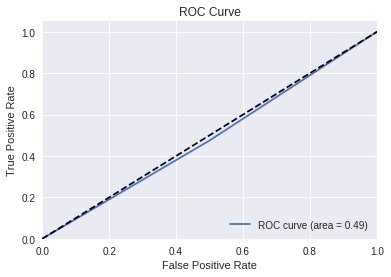

300

,score
precision,0.520 (+/- 0.014)
recall,0.537 (+/- 0.053)
f1,0.516 (+/- 0.015)
roc_auc,0.526 (+/- 0.018)


,test_score
precision,0.488
recall,0.476
f1,0.482
roc_auc,0.487


In [244]:
plot_roc_auc(y_test, y_pred_proba)
model.vector_size
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [245]:
dt300_sg_df = full_test_df.copy()

0    209
1    190
Name: y_pred, dtype: int64

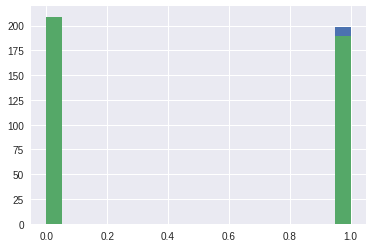

In [246]:
dt300_sg_df[dt300_sg_df.y_test == 0].y_pred.hist(bins=20)
dt300_sg_df[dt300_sg_df.y_test == 1].y_pred.hist(bins=20)
dt300_sg_df[dt300_sg_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

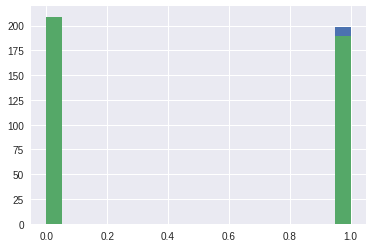

In [247]:
dt300_sg_df[dt300_sg_df.y_test == 0].y_pred_proba.hist(bins=20)
dt300_sg_df[dt300_sg_df.y_test == 1].y_pred_proba.hist(bins=20)

Display scores and detected positive samples

In [248]:
dt300_sg_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][dt300_sg_df.y_test==1].sort_values('y_pred_proba', ascending=False)
dt300_sg_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(dt300_sg_df.y_test == 1)&(dt300_sg_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
idx_list = dt300_sg_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(dt300_sg_df.y_test == 1)&(dt300_sg_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False).index.values.tolist()

#for i in idx_list:
#    print(dt300_sg_df.loc[i,'string'],'\n')

#for id_subset in dt300_sg_df.sample_id[(dt300_sg_df.y_test == 1)&(dt300_sg_df.y_pred == 1)].tolist():
#    print('comparison link:', '\t', 'https://fr.wikipedia.org/w/index.php?diff=' + str(df_XY.id[df_XY.sample_id==id_subset].values[0])+'&oldid='+str(int(df_XY.parentid[df_XY.sample_id==id_subset].values[0])),'\n')

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
382,from : chuq @ apple . com ( chuq von rospach )...,1,1,1,1.0,1220.0,278.0
395,organization : university of maine system from...,1,1,1,1.0,769.0,191.0
398,from : ummak027 @ ccu . umanitoba . ca ( anson...,1,1,1,1.0,966.0,293.0
403,from : leventhal @ cs . bgsu . edu ( laura lev...,1,1,1,1.0,432.0,78.0
404,from : mckinzie @ schaefer . math . wisc . edu...,1,1,1,1.0,1826.0,404.0
417,from : vergolin @ euler . lbs . msu . edu ( da...,1,1,1,1.0,932.0,186.0
421,from : leunggm @ odin . control . utoronto . c...,1,1,1,1.0,2836.0,633.0
428,from : nhmas @ gauss . med . harvard . edu ( m...,1,1,1,1.0,1538.0,334.0
432,from : htilney @ vax . clarku . edu subject : ...,1,1,1,1.0,370.0,82.0
440,subject : re : nords 3 - habs 2 in o . t . we ...,1,1,1,1.0,1153.0,255.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
5,from : rrhammer @ vm . cmp . ilstu . edu subje...,1,1,1,1.0,1069.0,217.0
557,from : gwittt @ alleg . edu ( tom gwitt ) subj...,1,1,1,1.0,537.0,126.0
522,from : yadallee @ ersys . edmonton . ab . ca (...,1,1,1,1.0,2007.0,412.0
526,from : paul @ fugu . data - io . com ( paul br...,1,1,1,1.0,670.0,154.0
533,from : allan @ cs . ualberta . ca ( allan sull...,1,1,1,1.0,1365.0,265.0
536,from : joe13 + @ pitt . edu ( joseph b stiehm ...,1,1,1,1.0,1748.0,391.0
541,from : farenebt @ craft . camp . clarkson . ed...,1,1,1,1.0,1711.0,398.0
543,"from : "" carl d . lovejoy "" < cl3d + @ andrew ...",1,1,1,1.0,1252.0,280.0
545,organization : penn state university from : ro...,1,1,1,1.0,1705.0,438.0
548,from : leunggm @ odin . control . utoronto . c...,1,1,1,1.0,2757.0,601.0
